In [30]:
import math
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchdyn.core import NeuralODE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ot.sliced import sliced_wasserstein_distance

In [31]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

In [32]:
S40 = pd.read_csv("data/station_40.csv")
S49 = pd.read_csv("data/station_49.csv")
S63 = pd.read_csv("data/station_63.csv")
S80 = pd.read_csv("data/station_80.csv")

S40.rename(columns=lambda x: x + "_40" if x != "YEAR" else x, inplace=True)
S49.rename(columns=lambda x: x + "_49" if x != "YEAR" else x, inplace=True)
S63.rename(columns=lambda x: x + "_63" if x != "YEAR" else x, inplace=True)
S80.rename(columns=lambda x: x + "_80" if x != "YEAR" else x, inplace=True)

merged_df = pd.merge(S40, S49, on='YEAR', how='inner')
merged_df = pd.merge(merged_df, S63, on='YEAR', how='inner')
dataset = pd.merge(merged_df, S80, on='YEAR', how='inner')

dataset.set_index('YEAR', inplace=True)
target = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_80']
features = [x for x in dataset.columns if x not in target]

print(dataset.shape)
dataset.head()

(10000, 76)


,W_1_40,W_2_40,W_3_40,W_4_40,W_5_40,W_6_40,W_7_40,W_8_40,W_9_40,W_10_40,...,W_10_80,W_11_80,W_12_80,W_13_80,W_14_80,W_15_80,W_16_80,W_17_80,W_18_80,YIELD_80
YEAR,,,,,,,,,,,,,,,,,,,,,
0,21.389266,26.985066,23.813756,26.852214,25.096705,26.852109,25.730293,23.416002,21.038240,5.739711,...,1.027391,1.228816,1.324273,2.309497,2.917570,0.769869,0.907157,3.401885,1.037317,10.51
1,21.314074,22.516442,24.072042,29.159849,29.522392,26.567033,28.249854,24.606161,19.268685,1.891106,...,0.143191,0.925005,2.751680,1.196560,0.784046,1.505209,0.240757,1.617603,1.818209,6.61
2,20.875083,26.038845,24.516708,27.633776,26.951667,27.926496,26.534607,25.968638,23.554623,4.745318,...,0.942601,1.811827,2.923051,0.384716,2.876004,1.535451,1.509938,1.652338,0.279352,6.86
3,20.553688,20.992986,22.859027,28.654018,26.705206,24.458350,25.146936,21.531644,22.961974,8.479863,...,3.640015,0.956474,2.241502,1.893830,0.189264,2.049275,3.795690,0.404447,1.468172,5.32
4,21.523342,21.542900,23.034072,26.327315,30.362289,27.503657,27.839165,29.764479,18.290963,3.405621,...,1.191167,0.049557,0.330440,2.860207,0.399063,0.506497,1.700047,0.216837,2.166599,6.32


In [33]:
dataset['Q40'] = (dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40'])
dataset['Q49'] = (dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49'])
dataset['Q63'] = (dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63'])
dataset['Q80'] = (dataset['W_13_80'] + dataset['W_14_80'] + dataset['W_15_80'])

features = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_80']
aux_columns = ['Q40', 'Q49', 'Q63', 'Q80']
nb_weather_var = len([x for x in dataset.columns if not (x in features or x in aux_columns) ])

dataset = dataset[(dataset['Q40'] <= 6.4897) & (dataset['Q49'] <= 3.3241) & (dataset['Q63'] <= 7.1301) & (dataset['Q80'] <= 5.1292)]
dataset.drop(['Q40', 'Q49', 'Q63', 'Q80'], axis=1, inplace=True)
print(dataset.shape)
dataset.head()

(1000, 76)


,W_1_40,W_2_40,W_3_40,W_4_40,W_5_40,W_6_40,W_7_40,W_8_40,W_9_40,W_10_40,...,W_10_80,W_11_80,W_12_80,W_13_80,W_14_80,W_15_80,W_16_80,W_17_80,W_18_80,YIELD_80
YEAR,,,,,,,,,,,,,,,,,,,,,
1,21.314074,22.516442,24.072042,29.159849,29.522392,26.567033,28.249854,24.606161,19.268685,1.891106,...,0.143191,0.925005,2.751680,1.196560,0.784046,1.505209,0.240757,1.617603,1.818209,6.61
2,20.875083,26.038845,24.516708,27.633776,26.951667,27.926496,26.534607,25.968638,23.554623,4.745318,...,0.942601,1.811827,2.923051,0.384716,2.876004,1.535451,1.509938,1.652338,0.279352,6.86
10,23.464658,23.112057,27.032350,26.348370,26.635686,27.142812,30.421238,24.051925,18.585785,0.692692,...,0.587621,0.473142,0.816458,0.573914,0.174179,2.236641,0.175408,2.514701,2.153090,6.04
28,24.495898,23.278987,23.563798,27.221256,25.471418,28.230339,27.622846,23.942648,20.273115,2.315491,...,0.169986,0.376775,1.874452,0.343077,1.527473,0.417273,0.691531,2.872908,1.997046,6.08
33,22.954317,23.373752,24.817940,26.166261,28.014204,29.420747,27.174332,26.733400,20.511923,0.827020,...,1.526391,3.749390,0.511152,0.536142,0.158058,0.958499,2.007874,0.499257,4.017396,3.51


In [34]:
#Some feature engineering for later

dataset['AvgTemp_1_40'] = (dataset['W_1_40'] + dataset['W_2_40'] + dataset['W_3_40'])/3
dataset['AvgTemp_1_49'] = (dataset['W_1_49'] + dataset['W_2_49'] + dataset['W_3_49'])/3
dataset['AvgTemp_1_63'] = (dataset['W_1_63'] + dataset['W_2_63'] + dataset['W_3_63'])/3
dataset['AvgTemp_1_80'] = (dataset['W_1_80'] + dataset['W_2_80'] + dataset['W_3_80'])/3

dataset['AvgTemp_2_40'] = (dataset['W_4_40'] + dataset['W_5_40'] + dataset['W_6_40'])/3
dataset['AvgTemp_2_49'] = (dataset['W_4_49'] + dataset['W_5_49'] + dataset['W_6_49'])/3
dataset['AvgTemp_2_63'] = (dataset['W_4_63'] + dataset['W_5_63'] + dataset['W_6_63'])/3
dataset['AvgTemp_2_80'] = (dataset['W_4_80'] + dataset['W_5_80'] + dataset['W_6_80'])/3

dataset['AvgTemp_3_40'] = (dataset['W_7_40'] + dataset['W_8_40'] + dataset['W_9_40'])/3
dataset['AvgTemp_3_49'] = (dataset['W_7_49'] + dataset['W_8_49'] + dataset['W_9_49'])/3
dataset['AvgTemp_3_63'] = (dataset['W_7_63'] + dataset['W_8_63'] + dataset['W_9_63'])/3
dataset['AvgTemp_3_80'] = (dataset['W_7_80'] + dataset['W_8_80'] + dataset['W_9_80'])/3

dataset['AvgWeath_1_40'] = (dataset['W_10_40'] + dataset['W_11_40'] + dataset['W_12_40'])/3
dataset['AvgWeath_1_49'] = (dataset['W_10_49'] + dataset['W_11_49'] + dataset['W_12_49'])/3
dataset['AvgWeath_1_63'] = (dataset['W_10_63'] + dataset['W_11_63'] + dataset['W_12_63'])/3
dataset['AvgWeath_1_80'] = (dataset['W_10_80'] + dataset['W_11_80'] + dataset['W_12_80'])/3

dataset['AvgWeath_2_40'] = (dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40'])/3
dataset['AvgWeath_2_49'] = (dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49'])/3
dataset['AvgWeath_2_63'] = (dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63'])/3
dataset['AvgWeath_2_80'] = (dataset['W_13_80'] + dataset['W_14_80'] + dataset['W_15_80'])/3

dataset['AvgWeath_3_40'] = (dataset['W_16_40'] + dataset['W_17_40'] + dataset['W_18_40'])/3
dataset['AvgWeath_3_49'] = (dataset['W_16_49'] + dataset['W_17_49'] + dataset['W_18_49'])/3
dataset['AvgWeath_3_63'] = (dataset['W_16_63'] + dataset['W_17_63'] + dataset['W_18_63'])/3
dataset['AvgWeath_3_80'] = (dataset['W_16_80'] + dataset['W_17_80'] + dataset['W_18_80'])/3

In [35]:
#Train / Test split :
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=seed)
X_train = train_data[features]
X_test = test_data[features]

In [36]:
class MLP(torch.nn.Module):
    def __init__(self, dim, cond_dim=0, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + cond_dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )
        self.cond_dim = cond_dim

    def forward(self, x):
        return torch.cat((self.net(x), torch.zeros((x.shape[0], self.cond_dim))), dim=1)
    

class CustomModel(torch.nn.Module):
    def __init__(self, dim, cond_dim=0, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.cond_dim = cond_dim
        # Define layers
        self.fc1 = torch.nn.Linear(dim + cond_dim + (1 if time_varying else 0), 4*w)  # First dense layer with input dimension 4 and output dimension 256
        self.fc2 = torch.nn.Linear(4*w, 4*w)  # Second dense layer
        self.fc3 = torch.nn.Linear(4*w, 2*w)  # Third dense layer
        self.fc4 = torch.nn.Linear(2*w, w)   # Fourth dense layer
        self.fc5 = torch.nn.Linear(w, out_dim)     # Output layer
        # Define dropout
        self.dropout = torch.nn.Dropout(0.4)
        # LeakyReLU activation functions with different negative slopes
        self.leaky_relu = torch.nn.LeakyReLU(0.2)

    def forward(self, x):
        # Apply layers with activations and dropout
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc5(x)  # No activation for the output layer
        return torch.cat((x, torch.zeros((x.shape[0], self.cond_dim))), dim=1)

# Flow matching on yields + weather

200: loss 0.282 time 3.30
400: loss 0.254 time 6.32
600: loss 0.241 time 9.31
800: loss 0.232 time 12.26
1000: loss 0.243 time 15.18
1200: loss 0.227 time 18.17
1400: loss 0.213 time 20.83
1600: loss 0.237 time 23.58
1800: loss 0.205 time 26.36
2000: loss 0.218 time 29.10


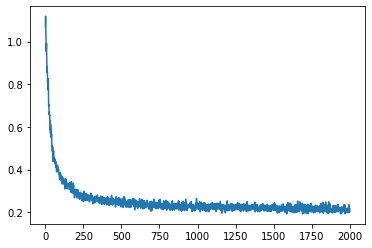

In [37]:
weather = ['AvgTemp_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in ['1','2','3']] + ['AvgWeath_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in ['1','2','3']]
X_all = train_data[features + weather]

scaler = StandardScaler()
X_all = pd.DataFrame(scaler.fit_transform(X_all))

sigma = 0.1
dim = X_all.shape[1]
batch_size = 256
model = MLP(dim=dim, time_varying=True, w=44)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

losses = []
start = time.time()
for k in range(2000):
    optimizer.zero_grad()

    x0 = torch.rand([batch_size,dim], dtype=torch.float32)
    x1 = torch.tensor(X_all.sample(n=batch_size, random_state=np.random.seed(seed)).values, dtype=torch.float32)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

plt.plot(losses)
plt.show()

In [38]:
nb_samples = 5000

with torch.no_grad():
    node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    x0 = torch.rand([nb_samples,dim], dtype=torch.float32)
    traj = node.trajectory(
            x0,
            t_span=torch.linspace(0, 1, 100),
            )
    samples = scaler.inverse_transform(traj[-1].cpu().numpy())[:,:4]

print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=5000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=5000)))

train SWD = 0.22107951538188256
test SWD = 0.21673883470984578


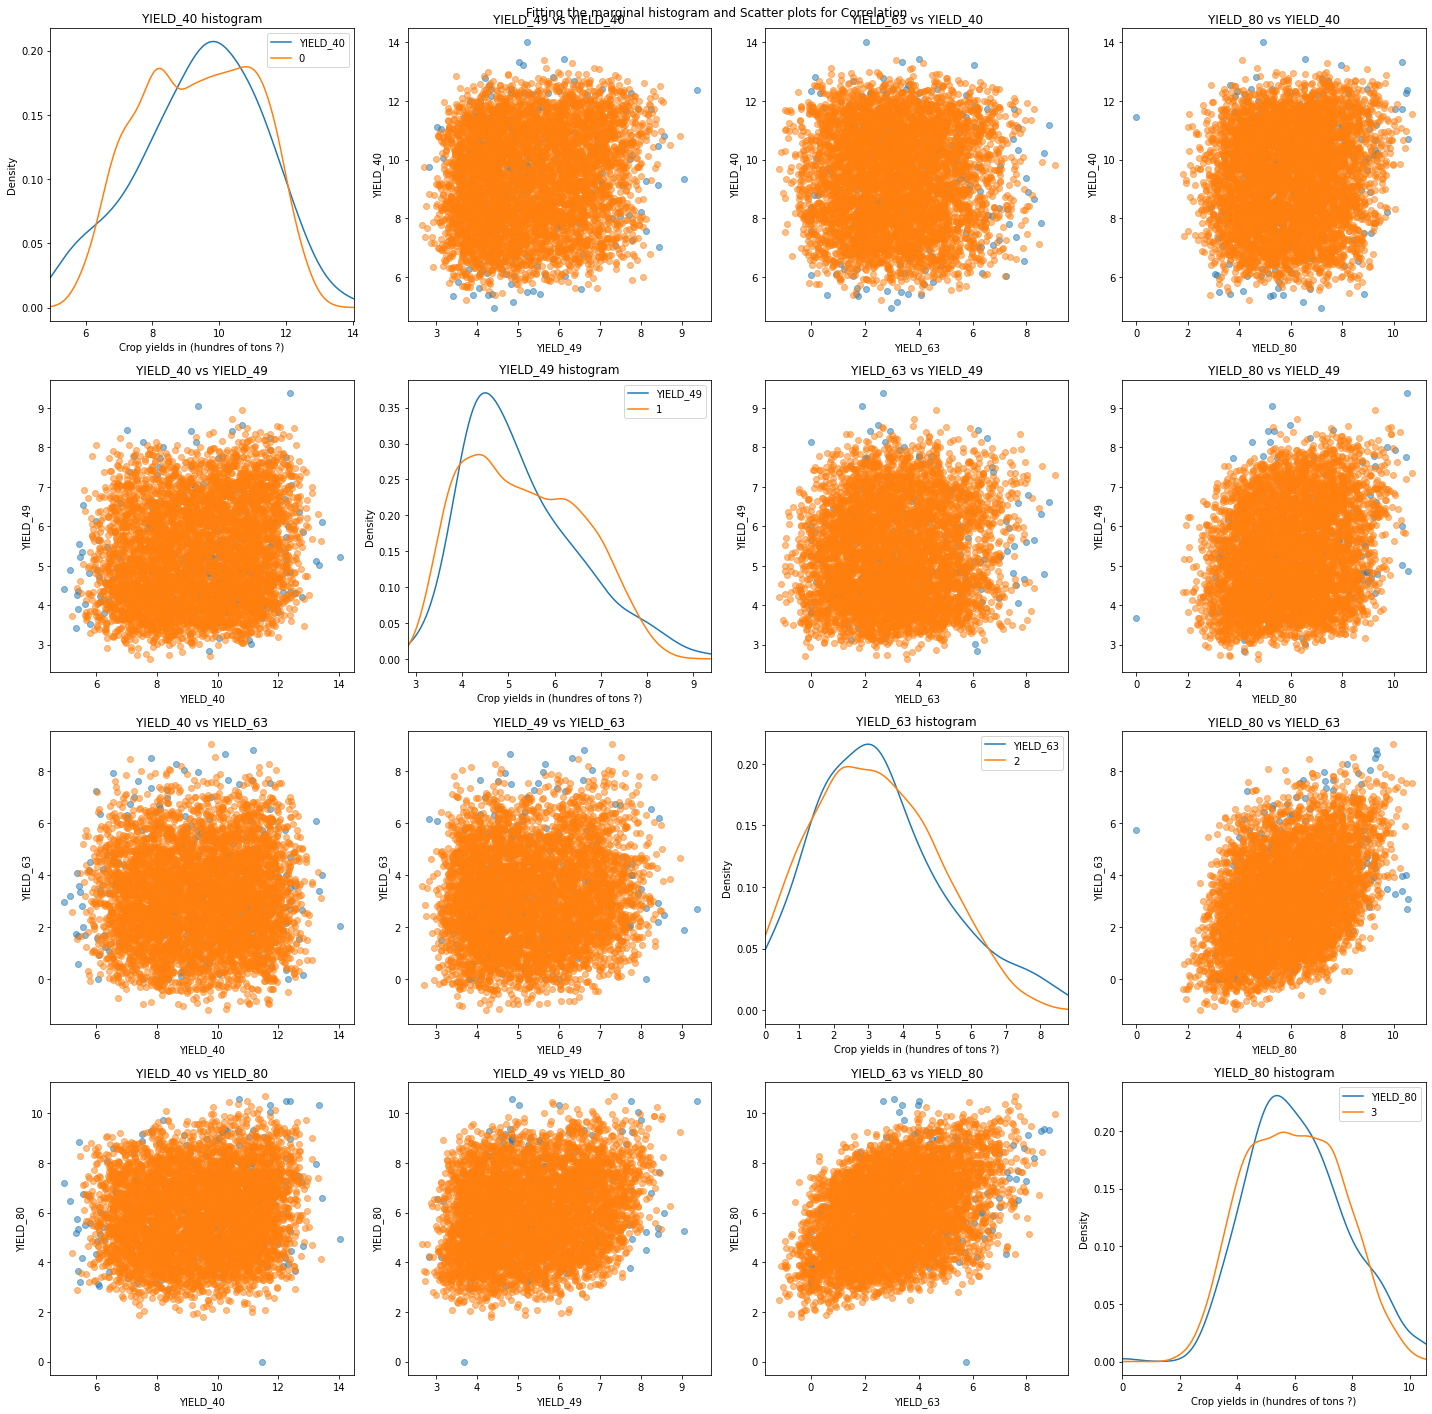

In [39]:
samples = pd.DataFrame(samples)

# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(4):
    yield_ind = X_test.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    X_test[yield_ind].plot.density()
    samples[k].plot.density()

    xmin, xmax = np.min(X_test[yield_ind]), np.max(X_test[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(4):
    for j in range(4):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = X_test.iloc[:, i]
            y = X_test.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)
            
            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X_train.columns[i]} vs {X_train.columns[j]}")
            plt.xlabel(X_train.columns[i])
            plt.ylabel(X_train.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()


# What if we use the whole dataset ? 

In [40]:
#Data import 
S40 = pd.read_csv("data/station_40.csv")
S49 = pd.read_csv("data/station_49.csv")
S63 = pd.read_csv("data/station_63.csv")
S80 = pd.read_csv("data/station_80.csv")

S40.rename(columns=lambda x: x + "_40" if x != "YEAR" else x, inplace=True)
S49.rename(columns=lambda x: x + "_49" if x != "YEAR" else x, inplace=True)
S63.rename(columns=lambda x: x + "_63" if x != "YEAR" else x, inplace=True)
S80.rename(columns=lambda x: x + "_80" if x != "YEAR" else x, inplace=True)

merged_df = pd.merge(S40, S49, on='YEAR', how='inner')
merged_df = pd.merge(merged_df, S63, on='YEAR', how='inner')
dataset = pd.merge(merged_df, S80, on='YEAR', how='inner')

dataset.set_index('YEAR', inplace=True)

#Some feature engineering for later

dataset['AvgTemp_1_40'] = (dataset['W_1_40'] + dataset['W_2_40'] + dataset['W_3_40'])/3
dataset['AvgTemp_1_49'] = (dataset['W_1_49'] + dataset['W_2_49'] + dataset['W_3_49'])/3
dataset['AvgTemp_1_63'] = (dataset['W_1_63'] + dataset['W_2_63'] + dataset['W_3_63'])/3
dataset['AvgTemp_1_80'] = (dataset['W_1_80'] + dataset['W_2_80'] + dataset['W_3_80'])/3

dataset['AvgTemp_2_40'] = (dataset['W_4_40'] + dataset['W_5_40'] + dataset['W_6_40'])/3
dataset['AvgTemp_2_49'] = (dataset['W_4_49'] + dataset['W_5_49'] + dataset['W_6_49'])/3
dataset['AvgTemp_2_63'] = (dataset['W_4_63'] + dataset['W_5_63'] + dataset['W_6_63'])/3
dataset['AvgTemp_2_80'] = (dataset['W_4_80'] + dataset['W_5_80'] + dataset['W_6_80'])/3

dataset['AvgTemp_3_40'] = (dataset['W_7_40'] + dataset['W_8_40'] + dataset['W_9_40'])/3
dataset['AvgTemp_3_49'] = (dataset['W_7_49'] + dataset['W_8_49'] + dataset['W_9_49'])/3
dataset['AvgTemp_3_63'] = (dataset['W_7_63'] + dataset['W_8_63'] + dataset['W_9_63'])/3
dataset['AvgTemp_3_80'] = (dataset['W_7_80'] + dataset['W_8_80'] + dataset['W_9_80'])/3

dataset['AvgWeath_1_40'] = (dataset['W_10_40'] + dataset['W_11_40'] + dataset['W_12_40'])/3
dataset['AvgWeath_1_49'] = (dataset['W_10_49'] + dataset['W_11_49'] + dataset['W_12_49'])/3
dataset['AvgWeath_1_63'] = (dataset['W_10_63'] + dataset['W_11_63'] + dataset['W_12_63'])/3
dataset['AvgWeath_1_80'] = (dataset['W_10_80'] + dataset['W_11_80'] + dataset['W_12_80'])/3

dataset['AvgWeath_2_40'] = (dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40'])/3
dataset['AvgWeath_2_49'] = (dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49'])/3
dataset['AvgWeath_2_63'] = (dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63'])/3
dataset['AvgWeath_2_80'] = (dataset['W_13_80'] + dataset['W_14_80'] + dataset['W_15_80'])/3

dataset['AvgWeath_3_40'] = (dataset['W_16_40'] + dataset['W_17_40'] + dataset['W_18_40'])/3
dataset['AvgWeath_3_49'] = (dataset['W_16_49'] + dataset['W_17_49'] + dataset['W_18_49'])/3
dataset['AvgWeath_3_63'] = (dataset['W_16_63'] + dataset['W_17_63'] + dataset['W_18_63'])/3
dataset['AvgWeath_3_80'] = (dataset['W_16_80'] + dataset['W_17_80'] + dataset['W_18_80'])/3

dataset['Q40'] = (dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40'])
dataset['Q49'] = (dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49'])
dataset['Q63'] = (dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63'])
dataset['Q80'] = (dataset['W_13_80'] + dataset['W_14_80'] + dataset['W_15_80'])

#Train / Test split :
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=seed)

200: loss 0.164 time 11.09
400: loss 0.136 time 22.42
600: loss 0.126 time 33.09
800: loss 0.118 time 43.68
1000: loss 0.115 time 54.15
1200: loss 0.115 time 64.59
1400: loss 0.116 time 75.09
1600: loss 0.110 time 94.20
1800: loss 0.114 time 108.59
2000: loss 0.103 time 129.82


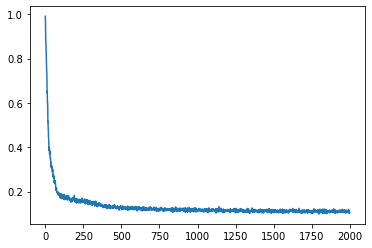

In [41]:
weather = ['AvgTemp_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in ['2']] + ['AvgWeath_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in ['2']]
aux = ['Q40', 'Q49', 'Q63', 'Q80']
X_all = train_data[features + aux + weather]

scaler = StandardScaler()
X_all = pd.DataFrame(scaler.fit_transform(X_all))

sigma = 0.1
dim = X_all.shape[1]
batch_size = 512
model = MLP(dim=dim, time_varying=True, w=44)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

losses = []
start = time.time()
for k in range(2000):
    optimizer.zero_grad()

    x0 = torch.rand([batch_size,dim], dtype=torch.float32)
    x1 = torch.tensor(X_all.sample(n=batch_size, random_state=np.random.seed(seed)).values, dtype=torch.float32)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

plt.plot(losses)
plt.show()

In [47]:
nb_samples=300
k = 0
l = []

node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

while k<nb_samples:
    with torch.no_grad() :
        x0 = torch.rand([1000,dim], dtype=torch.float32)
        traj = node.trajectory(
                x0,
                t_span=torch.linspace(0, 1, 100),
                )
        s = scaler.inverse_transform(traj[-1].cpu().numpy())
        q = s[:,4:8]
        for i in range(1000):
            if q[i,0] <= 6.4897 and q[i,1] <= 3.3241 and q[i,2] <= 7.1301 and q[i,3] <= 5.1292:
                l.append(q[i])
                k+= 1

samples = np.array(l)

print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=5000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=5000)))

train SWD = 3.2921029823613037
test SWD = 3.2399463819155208
